# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

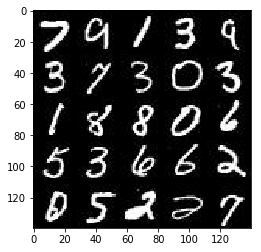

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

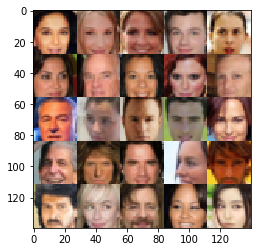

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_data = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_data, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    base_shape = images.get_shape().as_list()[1]
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Shape 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1*0.2, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        # From How to Train a GAN? Tips and tricks to make GANs work
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        x2 = tf.maximum(x2*0.2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        x3 = tf.maximum(x3*0.2, x3)
        # 7x7x256
        
        #x3 = tf.layers.conv2d(x2, 256, 5, strides=5, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=True)
        #x3 = tf.maximum(x3*0.2, x3)
        
        flattened = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
#         x1 = tf.layers.dense(z, 7*7*1024)
        
#         x1 = tf.reshape(x1, (-1, 7, 7, 1024))
#         x1 = tf.layers.batch_normalization(x1, training=is_train)
#         x1 = tf.nn.dropout(x1, keep_prob=0.5)
#         x1 = tf.maximum(x1*0.2, x1)
        # 7x7x1024
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
#         x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same',
#                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x1, training=is_train)
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        x2 = tf.maximum(x2*0.2, x2)
        # 7x7x512
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        x3 = tf.maximum(x3*0.2, x3)
        # 14x14x256
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.nn.dropout(x4, keep_prob=0.5)
        x4 = tf.maximum(x4*0.2, x4)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    losses = []
    image_channels = 1 if data_image_mode == 'L' else 3
    image_width = data_shape[1]
    image_height = data_shape[2]
    input_data, z_data, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_data, z_data, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images = batch_images*2
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #Run Optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_data: batch_images, z_data: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_data: batch_images, z_data: batch_z, lr: learning_rate})
                # _ = sess.run(g_train_opt, feed_dict = {input_data: batch_images, z_data: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_data: batch_images, z_data: batch_z})
                    train_loss_g = g_loss.eval({input_data: batch_images, z_data: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps%100 == 0:
                    show_generator_output(sess, 10, z_data, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6502... Generator Loss: 2.6721
Epoch 1/2... Discriminator Loss: 0.7152... Generator Loss: 2.5371
Epoch 1/2... Discriminator Loss: 0.8886... Generator Loss: 2.2533
Epoch 1/2... Discriminator Loss: 0.8195... Generator Loss: 1.8561
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 2.8478
Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 2.4084
Epoch 1/2... Discriminator Loss: 0.6384... Generator Loss: 3.4120
Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 3.0724
Epoch 1/2... Discriminator Loss: 0.6723... Generator Loss: 3.1083


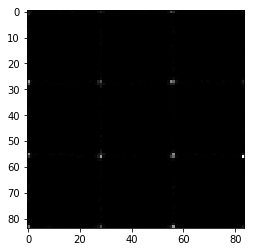

Epoch 1/2... Discriminator Loss: 0.5580... Generator Loss: 3.6345
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 2.6109
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 3.5263
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 3.5680
Epoch 1/2... Discriminator Loss: 0.7249... Generator Loss: 2.8691
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 2.2275
Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 2.2058
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.5833
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 2.2546
Epoch 1/2... Discriminator Loss: 0.8026... Generator Loss: 3.0383


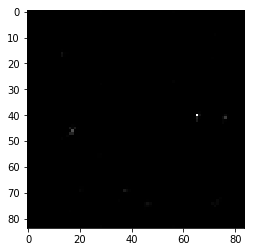

Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 3.2462
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 1.4178
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 3.5853
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 2.5025
Epoch 1/2... Discriminator Loss: 0.7111... Generator Loss: 2.8718
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.9818
Epoch 1/2... Discriminator Loss: 0.7573... Generator Loss: 3.5776
Epoch 1/2... Discriminator Loss: 0.7551... Generator Loss: 2.0694
Epoch 1/2... Discriminator Loss: 0.6609... Generator Loss: 2.5903
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 2.1151


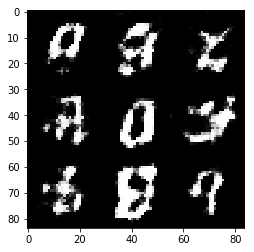

Epoch 1/2... Discriminator Loss: 0.7099... Generator Loss: 2.7658
Epoch 1/2... Discriminator Loss: 0.9198... Generator Loss: 3.2244
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.7838
Epoch 1/2... Discriminator Loss: 0.9788... Generator Loss: 1.4179
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 2.9899
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 3.2496
Epoch 1/2... Discriminator Loss: 0.7739... Generator Loss: 2.7453
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 2.3766
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 2.7136
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 3.0820


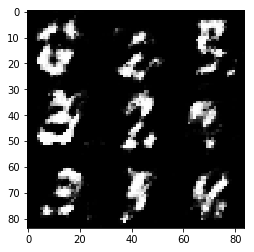

Epoch 1/2... Discriminator Loss: 0.6352... Generator Loss: 3.5927
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 2.6115
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 1.6663
Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 1.0184
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 3.1371
Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 2.0183
Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 3.1725
Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 2.0758
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 1.4450
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 2.9703


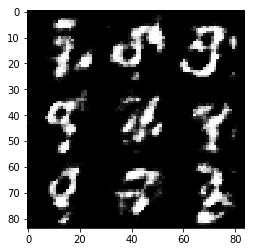

Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 3.8869
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.9795
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 2.0349
Epoch 1/2... Discriminator Loss: 0.7083... Generator Loss: 2.6987
Epoch 1/2... Discriminator Loss: 0.8747... Generator Loss: 2.0107
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.5932
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.5415
Epoch 1/2... Discriminator Loss: 0.7732... Generator Loss: 2.8788
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 1.6320
Epoch 1/2... Discriminator Loss: 0.8771... Generator Loss: 2.4038


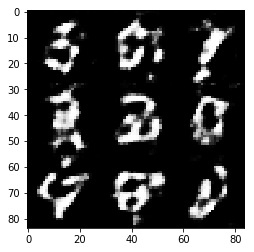

Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 2.5704
Epoch 1/2... Discriminator Loss: 0.6762... Generator Loss: 2.3693
Epoch 1/2... Discriminator Loss: 0.7249... Generator Loss: 2.9365
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 2.6779
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 2.6937
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 2.3215
Epoch 1/2... Discriminator Loss: 0.7994... Generator Loss: 2.7339
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 2.7643
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 2.6560
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 2.2809


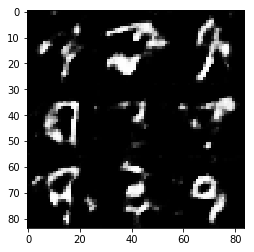

Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 1.4297
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 2.2121
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.9852
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 2.5126
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 2.4926
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 3.7372
Epoch 1/2... Discriminator Loss: 1.0849... Generator Loss: 1.2739
Epoch 1/2... Discriminator Loss: 0.8377... Generator Loss: 2.0775
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 1.9178
Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 2.0568


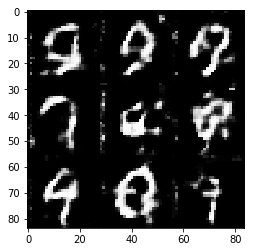

Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 1.7365
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 1.8634
Epoch 1/2... Discriminator Loss: 0.7326... Generator Loss: 2.1318
Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 1.8655
Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 2.9716
Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 2.4949
Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 2.1160
Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 3.1331
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 3.2146
Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 1.9974


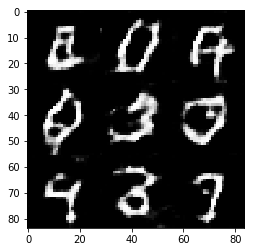

Epoch 1/2... Discriminator Loss: 0.8457... Generator Loss: 1.8302
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 2.7878
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 3.3474
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 1.2691
Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 1.9859
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 3.0826
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 1.9558
Epoch 2/2... Discriminator Loss: 0.9166... Generator Loss: 4.1522
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 2.7204
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 2.1110


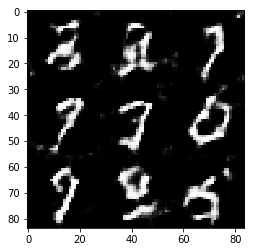

Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 3.2637
Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 2.6785
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.5699
Epoch 2/2... Discriminator Loss: 1.4934... Generator Loss: 0.9904
Epoch 2/2... Discriminator Loss: 0.7012... Generator Loss: 1.9478
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 1.8042
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 1.9538
Epoch 2/2... Discriminator Loss: 0.8270... Generator Loss: 2.2655
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 3.3987
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 2.8044


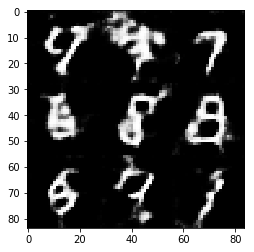

Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 3.2772
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 1.8928
Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 2.3018
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 3.1112
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 1.6409
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 2.8256
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.7351
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 1.8427
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 1.8710
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.7594


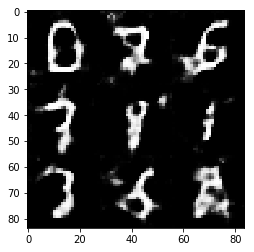

Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 1.8770
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 1.3836
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 2.7684
Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 1.8344
Epoch 2/2... Discriminator Loss: 0.9452... Generator Loss: 1.7445
Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 2.0044
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.9593
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 2.0330
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.7021
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.4754


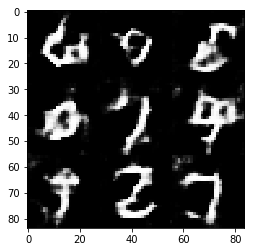

Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 1.5042
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.7849
Epoch 2/2... Discriminator Loss: 1.9637... Generator Loss: 4.0542
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.5210
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 2.5048
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 2.2771
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 2.4400
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 2.2945
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 2.5860
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 2.2844


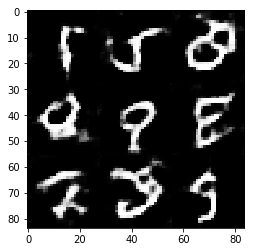

Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 3.3811
Epoch 2/2... Discriminator Loss: 0.8255... Generator Loss: 1.9603
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.5435
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.7438
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 2.1337
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.7446
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 2.3779
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 2.2910
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 1.3877
Epoch 2/2... Discriminator Loss: 0.9681... Generator Loss: 1.7965


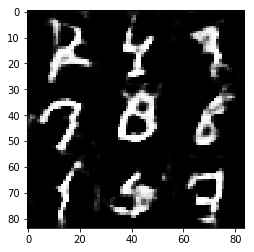

Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 1.9511
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 1.8312
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 1.3170
Epoch 2/2... Discriminator Loss: 0.8419... Generator Loss: 1.5218
Epoch 2/2... Discriminator Loss: 1.2643... Generator Loss: 1.1418
Epoch 2/2... Discriminator Loss: 1.1437... Generator Loss: 0.9379
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 3.8687
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 1.8658


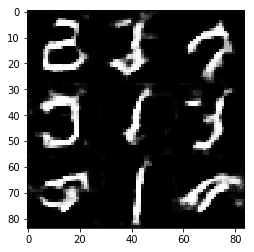

Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 2.3827
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 1.3055
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 2.2116
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 2.5010
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.7529
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.9534
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 3.8349
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 1.7810
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 1.7785
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 3.2500


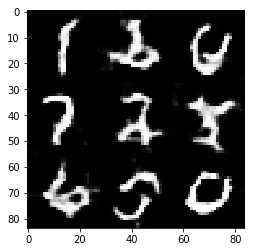

Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 1.6823
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 2.0424
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 1.7058
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 1.4900
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 2.1159
Epoch 2/2... Discriminator Loss: 0.9881... Generator Loss: 2.0547
Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 1.6917
Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 2.5296
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 1.7568
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 1.5125


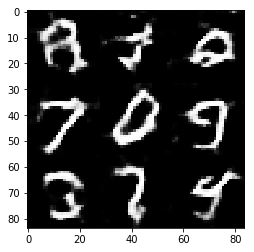

Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.7239
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.5850
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 1.9713
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.0865
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 2.6157
Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 1.8857
Epoch 2/2... Discriminator Loss: 0.8972... Generator Loss: 2.0135


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 2.3967
Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 3.4186
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 3.7976
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 3.7027
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 3.7928
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 3.9207
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 3.6118
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 3.8407
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 3.1870
Epoch 1/1... Discriminator Loss: 0.4553... Generator Loss: 4.3000


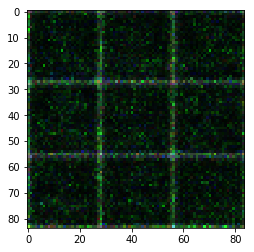

Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 3.8337
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 4.3203
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 4.4742
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 3.2792
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 4.2221
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 4.6531
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 4.2136
Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 3.7941
Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 3.7750
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 4.1838


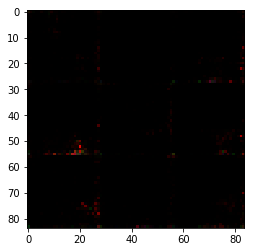

Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 5.0069
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 4.5760
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 4.2867
Epoch 1/1... Discriminator Loss: 0.4508... Generator Loss: 4.5897
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 4.7271
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 5.2643
Epoch 1/1... Discriminator Loss: 0.4542... Generator Loss: 4.9011
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 5.9520
Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 5.3333
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 6.3917


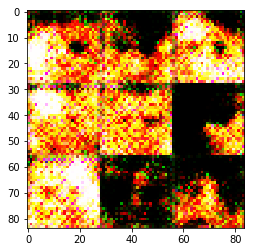

Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 5.7992
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 4.9743
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 5.5078
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 5.0737
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 4.1647
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 4.7609
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 6.1409
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 5.0843
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 6.3348
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 6.2373


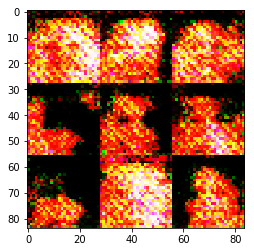

Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 6.2410
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 6.4729
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 6.2585
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 5.9891
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 5.2753
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 5.3238
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 5.9169
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 5.3965
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 4.0186
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 4.2200


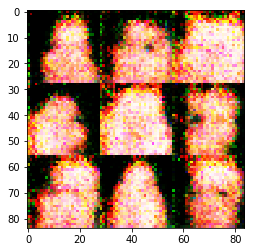

Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 3.4614
Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 4.7876
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 3.4588
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 5.4958
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 5.5429
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 4.3429
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 5.2544
Epoch 1/1... Discriminator Loss: 0.4340... Generator Loss: 4.4146
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 5.7378
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 5.3525


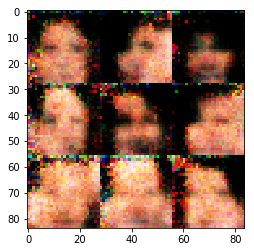

Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 4.2819
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 4.7120
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 4.8367
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 3.0794
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 5.3644
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 4.4348
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 5.1490
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 4.5563
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 4.7449
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 4.6977


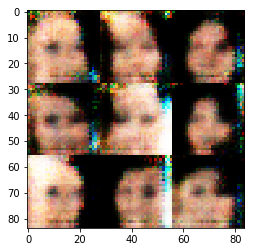

Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 4.0524
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 4.2842
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 5.1326
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.8981
Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 4.6573
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 4.8649
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 5.5781
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 3.6696
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 4.5142


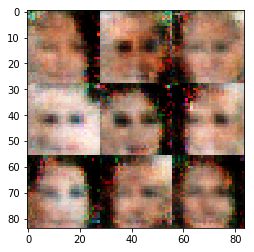

Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 6.7812
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 3.5016
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 3.8464
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 2.2443
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 3.7038
Epoch 1/1... Discriminator Loss: 0.6762... Generator Loss: 2.5698
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 3.2500
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 4.0456
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 3.2794
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 2.7465


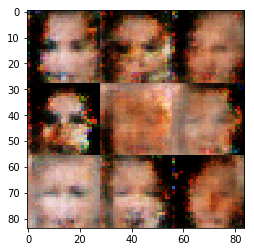

Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 2.9116
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 3.1628
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 4.2745
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 2.6057
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 2.6510
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 3.0388
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 2.7505
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 2.4731
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 3.1370
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 3.7266


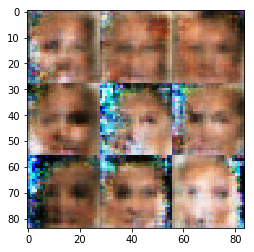

Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 2.1453
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 3.0354
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.6136
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 2.7373
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.9172
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 2.8740
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.6329
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.9087
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 2.3527


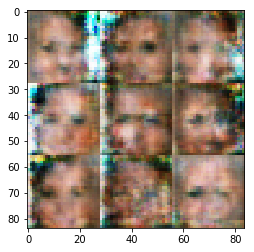

Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 2.0806
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 2.2119
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.9978
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.8490
Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 2.2382
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.8816
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.7744
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.7735


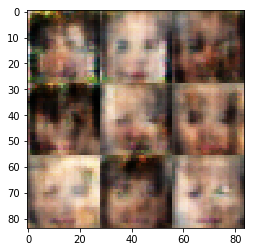

Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 3.0787
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 2.4246
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 2.6871
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 2.1827
Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 3.1387
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 2.7025
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 2.1510
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 2.5788
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.5941


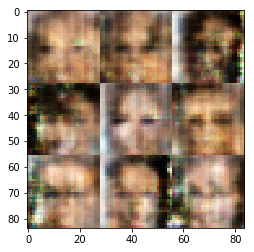

Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 2.4621
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.8801
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 2.0060
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 2.4124
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 2.3207
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.8250
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.4005
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 3.1346
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 2.4824
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.9742


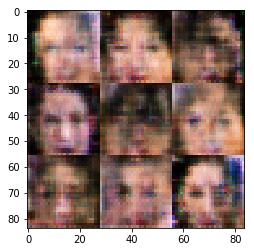

Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 2.0426
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 2.8228
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 2.0345
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.9118
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.8999
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 2.6334
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 2.2320
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.7115
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 2.3167
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 2.0296


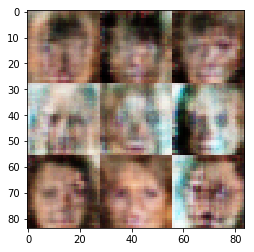

Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.6424
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 2.3679
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.9509
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 2.2963
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.6197
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.8320
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.9806
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 2.2280
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 2.0336


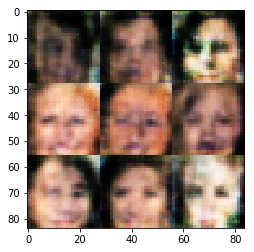

Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.8205
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 2.0860
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.9852
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 2.2014
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.8022
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 2.1487
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 2.2418
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.9357
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 2.7797


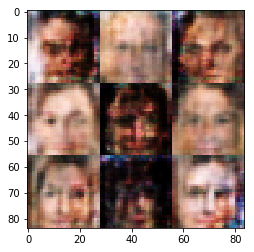

Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 2.2282
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.7885
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 2.1403
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.5528
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.7175
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.7754


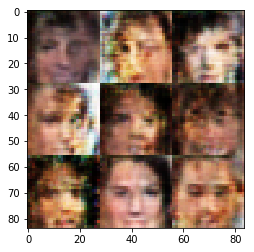

Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 2.2174
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 2.3871
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.7536
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.8730
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.3343
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.7933
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.6881


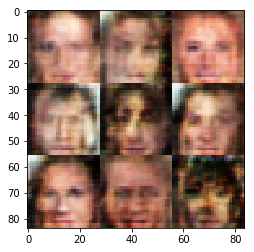

Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 2.2968
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.4486
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 2.0546
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 1.6736
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 2.1155


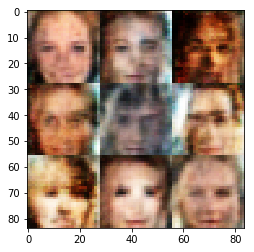

Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 2.0017
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.9843
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.8929
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.5684


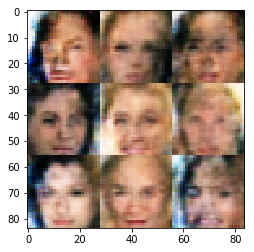

Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.7911
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.6190
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 1.3472
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.8289
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.5272


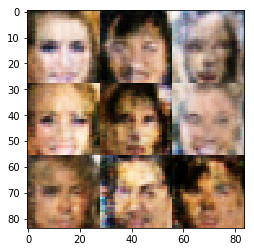

Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 2.0823
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.6928
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.8592
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.6452
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.9055
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 1.2560


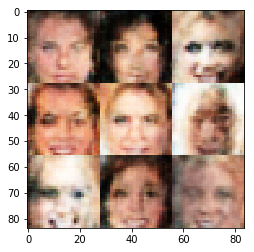

Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.8198
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.7550
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.6435
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.3526
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.1939


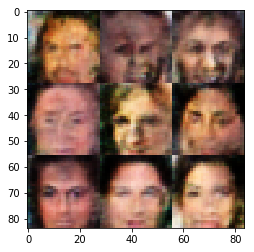

Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.8131
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.7059
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.9900
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.8444
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 2.0545


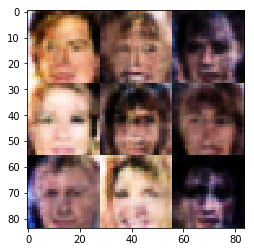

Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.8429
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 2.0534
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.6181
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.9147
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.7330


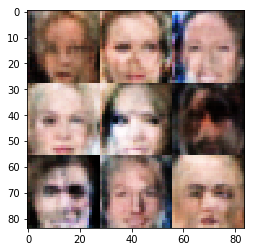

Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.8533
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 2.0056
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.5343
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.7113
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.3979
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.7586
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 1.2291


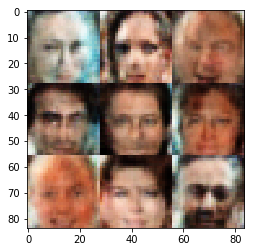

Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.6138
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.4456
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 2.2599
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.8688
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.8344


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.